Updated checkpoints: https://disk.yandex.ru/d/cK1PQ1-nn3PbKg

# Домашнее задание

1) В этой домашней работе вам предстоит решить задачу сегментации объект/фон на датасете PascalVoc2012. . Это такая же задача, как мы решали на семинаре, поэтому пользуйтесь наработками и рекомендациями
2) необходимо дополнить список аугментаций (>= 2) : https://pytorch.org/vision/master/transforms.html , https://albumentations.ai
3) Добавить понятные метрики на валидацию mean-IoU 
4) Добавить лосс Jaccard loss или DICE loss к BCE: https://arxiv.org/pdf/2006.14822.pdf
5) Взять непредобученную модель(можно использовать UNET из семинара, взять другую, реализовать свою) 
6) Пообучать модель несколько эпох 
7) Показать результаты работы - графики mean-IoU, лосс и примеры работы


In [1]:
data_path = "data"
checkpoints_path = f"{data_path}/models"
checkpoints_file = "checkpoints.zip"

# Prepare data

In [12]:
# !wget https://data.deepai.org/PascalVOC2012.zip
# !unzip PascalVOC2012.zip -d 'data/VOC'
# !mv voc2012 VOCdevkit
# !pip install segmentation_models_pytorch
# !python -m pip install pytorch-lightning

In [3]:
# !pip3 install segmentation_models_pytorch
# !python3 -m pip install pytorch-lightning

In [4]:
# import os
# from zipfile import ZipFile
# if not os.path.exists(checkpoints_path):
#     raise FileNotFoundError("Скачайте архив с обученными моделями")

# with ZipFile(f"{checkpoints_path}/{checkpoints_file}", "r") as zf:
#     zf.extractall(checkpoints_path)

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random

import cv2
import torch
import torchvision
import numpy as np
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.datasets import VOCSegmentation

print("Torch", torch.__version__)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    DEVICE="cuda"
    print("Use CUDA")
else:
    DEVICE="cpu"
    
# Параметры тренировки и визуализации.
TRAIN = True  # Если False, будут использоваться заранее посчитанные графики
              # вместо реальной тренировки (полезно для демонстрации на ноутбуках без GPU).

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Torch 2.0.1+cu117


In [13]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "potted_plant", "sheep", "sofa", "train", "tv/monitor"]
MULTICLASS = False  # Если False, отделяем объекты от фона, иначе распознаем класс объектов.
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 2


Mask values: {0, 4, 255}


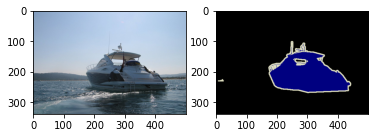

In [21]:
# Посмотрим на валидационную часть корпуса.
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=False)

image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

Маска содержит номера классов для каждого пикселя. Имеется две специальные метки: 0 для фона и 255 для контура. Контур мы уберем.

In [17]:
for _ in range(5):
    i = random.randint(0, len(valset_raw) - 1)
    print("Image {:05d} size: {}".format(i, valset_raw[i][0].size))

Image 00260 size: (500, 374)
Image 00226 size: (500, 332)
Image 00741 size: (500, 500)
Image 00473 size: (500, 333)
Image 01383 size: (500, 332)


In [30]:
import cv2
import random
import numpy as np
from PIL import Image


class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_offset=0.1, rotate=True):
        self._min_scale = min_scale
        self._max_offset = max_offset
        self._rotate = rotate

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        mask = np.array(mask)
        h, w, c = image.shape
        assert c == 3
        if self._rotate:
            angle = random.random() * np.pi / 2 - np.pi / 4
        else:
            angle = 0
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        rotation = cv2.getRotationMatrix2D(((w // 2), (h // 2)), angle * 180 / np.pi, scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        rotation[:, 2] += [x_offset, y_offset]
        new_image = cv2.warpAffine(image, rotation, (w, h), borderValue=(128, 128, 128))
        new_mask = cv2.warpAffine(mask, rotation, (w, h), borderValue=(0, 0, 0), flags=cv2.INTER_NEAREST)
        return new_image, new_mask  # Numpy -> PIL.


class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        new_image = image.astype(np.float16)
        new_image += 255 * brightness
        new_image = (new_image - 128) * contrast + 128
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.


class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel

    def __call__(self, image, mask):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image, mask
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        new_image = cv2.GaussianBlur(image, (kernel, kernel), sigmaX=kernel / 2)
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.
    
    
class FlipAugmenter(object):
    def __call__(self, image, mask):
        a = random.randint(0, 3)
        if a == 0:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
        elif a == 1:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        elif a == 2:
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        return image, mask


class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)

    def __call__(self, image, mask):
        augmenter = random.choice(self._augmenters)
        return augmenter(image, mask)


In [29]:
def image_to_numpy(image):
    """Convert Torch tensor to Numpy image."""
    if isinstance(image, np.ndarray):
        return image
    if image.dtype == torch.float32:
        image = image - image.min()
        image = 255 * image / max(1e-6, image.max())
    return image.to(torch.uint8).permute(1, 2, 0).cpu().numpy()

def image_to_torch(image, device=None):
    """Convert Numpy image to Torch tensor."""
    if isinstance(image, torch.Tensor):
        return image
    if image.shape[-1] == 4:
        image = image[..., :3]
    result = torch.from_numpy(np.ascontiguousarray(image))
    if device is not None:
        result = result.to(device)
    result = result.permute(2, 0, 1)
    return result

In [33]:
class Scaler(object):
    """Отмасштабировать изображения сохранив пропорции.
    
    Пустые места будут заполнены отражениями.

    Аргументы:
        image: Изображение в HWC формате.
        size: Требуемый размер, пара W, H.
    """
    def __init__(self, size):
        self._size = size
        self._padding = 0
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]
        
        if grayscale:
            result = result[:, :, 0]
        return result

    
def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask
    

class VOCDataset(torch.utils.data.Dataset):
    """Обертка для стандартного класса, которая форматирует данные."""
    def __init__(self, root, year, image_size,
                 multiclass=MULTICLASS,
                 download=False, augment=False,
                 train=False, train_fraction=0.8,
                 padding=0):
        """Создать корпус.
        
        Аргументы:
            root: Путь до папки для хранения данных.
            year: 2007 или 2012.
            image_size: Ширина и высота изображений.
            download: Скачать корпус, если он не найден в папке.
            augment: Применить аугментации.
            train: Выделить train часть, иначе validation.
            train_fraction: Доля тренировочных примеров.
            padding: Добавить дополнительный зеркальынй паддинг к изображению.
        """
        self._dataset = VOCSegmentation(root, str(year), "trainval", download=download)
        self._image_size = np.array(image_size)
        self._multiclass = multiclass
        self._padding = padding
        
        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size)
        if augment:
            self._augmenter = RandomAugmentation(AffineAugmenter(),
                                                 BrightnessContrastAugmenter(),
                                                 BlurAugmenter(),
                                                 FlipAugmenter())
        else:
            self._augmenter = lambda image, mask: (image, mask)
        
    @property
    def image_size(self):
        return self._image_size + self._padding * 2
    
    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)
        self._mask_scaler.set_padding(padding)
        
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        image = np.asarray(image)
        mask = np.array(mask)
        remove_borders_inplace(mask)
        if not self._multiclass:
            mask[mask > 0] = 1
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        image, mask = self._augmenter(image, mask)
        image = image_to_torch(image).float() - 0.5
        mask = image_to_torch(mask[..., None]).long()[0]
        return image, mask

IMAGE_SIZE = 512  # В исходной статье U-Net применяется к изображениям размера 572.

# Корпус был загружен выше, download = False.
trainset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                      multiclass=MULTICLASS, train=True)
valset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                    multiclass=MULTICLASS, train=False)
print("Image size:", IMAGE_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: 512
Train set size: 2330
Validation set size: 583


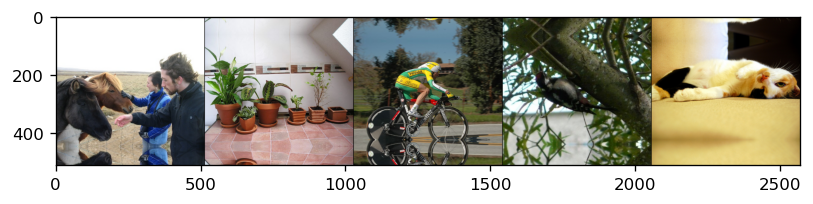

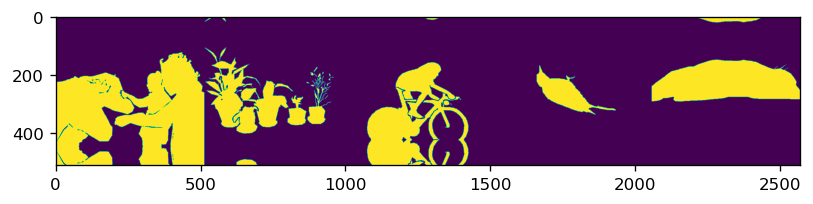

In [34]:
def show_dataset(dataset):
    images = []
    masks = []
    for _ in range(5):
        i = random.randint(0, len(valset) - 1)
        if len(images):
            separator = np.zeros((dataset.image_size[0], 2, 3), dtype=np.uint8)
            images.append(separator)
            masks.append(separator[:, :, 0])
        image, mask = dataset[i]
        images.append(image_to_numpy(image))
        masks.append(image_to_numpy(mask[None, ...])[..., 0])

    %matplotlib inline
    set_figure_size()
    plt.imshow(np.concatenate(images, axis=1))
    plt.show()
    set_figure_size()
    plt.imshow(np.concatenate(masks, axis=1))
    plt.show()
    
valset.set_padding(0)
show_dataset(trainset)